## 使用注意力机制的seq2seq

- 在seq2seq模型中，在一个batch的数据的前向传播中，我们使用encoder中RNN的最后一个时间步的最后一层的输出作为decoder层context的初始化，这个context包含了源序列中的所有的信息，但是已经很有可能被压扁了，信息有一定的损失了，并且我们在预测前面的单词的时候可能更需要看源语言的前面的单词，所以我们可以把context改成不使用上述初始化的方式，而是使用注意力的方式，在每次decoder前向传播的过程中，使用上一个时间步预测出的值对应的隐状态当作query，encoder中输出的state当作key和value，进行attention计算，成为context信息进行前向传播

<img src='../images/66image1.png' width='500'>

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class AttentionDecoder(d2l.Decoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    @property
    def attention_weights(self):
        raise NotImplementedError

- 在62seq2seq模型中，我们定义的encoder使用的是torch实现的GRU单元，在一个batch中输出的值是output[num_steps, bs, num_hiddens]是每个时间步中最后一层隐藏状态的值，state[num_layers, bs, num_hiddens]
- 所以我们新的使用attention模型的decoder并不需要改变encoder，只需要改变decoder

In [ ]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self,  vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
    
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        """"
        enc_outputs [num_steps, bs, num_hiddens]
        hidden_state [num_layers, bs, num_hiddens]
        """
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        """
        X [bs, num_steps, vocab_size]
        state init_state函数的返回值
        enc_outputs [bs, num_steps, num_hiddens]
        hidden_state [num_layers, bs, num_hiddens]
        """
        enc_outputs, hidden_state, enc_valid_lens = state
        # [num_steps, bs, embed_size]
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        # 因为每一步都要单独计算context，所以就不能直接生成context给gru
        # 而是需要单独一步一步计算
        for x in X: # 每次算一个时间步 x[bs,embed_size]
            # [bs, 1, num_hiddens] 把每次decoder的隐藏状态的输出作为query，
            # 如果是第一个，那么把encoder的最后一层的隐藏状态作为query
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # [bs, n_q, num_hiddens] k/enc_outpus[bs, nk/num_steps, num_hiddens]
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            # x[bs, 1, num_hiddens + embed_size]
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # out [1, bs, num_hiddens] hidden_state[num_layers, bs, num_hiddens]
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            #     list[tensor]                           [bs, 1(n_q), n_k]
            self._attention_weights.append(self.attention.attention_weights)
        # [num_steps, bs, num_outputs]
        outputs = self.dense(torch.cat(outputs, dim=0))
        # [bs, num_steps, num_outputs]     
        return (outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens])
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [5]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long) # [bs, num_steps]
state = decoder.init_state(encoder(X), None)

In [6]:
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, state[1].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), torch.Size([2, 4, 16]))

- 训练

loss 0.018, 8782.2 tokens/sec on cuda:0


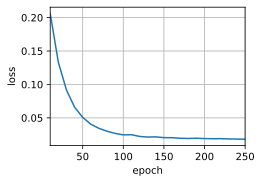

In [7]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [21]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est riche .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [27]:
# dec_attention_weight_seq是最后一个翻译任务的attention_weights的列表,存了很多个个注意力权重矩阵,是一个list of list
# 每一个list是单步预测的时候返回值注意力权重，因此外层list的长度是句子的长度，里面list中含有一个三维tensor[bs, n_q, n_k]
# 然后因为最后一句话预测了六步，每一次query都有10个注意力权重，因此注意力权重为6 x 10, 每行表示第i个query与源句子中的注意力权重
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape(1, 1, -1, num_steps)
dec_attention_weight_seq[0][0][0].shape, attention_weights.numel(), attention_weights.shape

(torch.Size([1, 10]), 60, torch.Size([1, 1, 6, 10]))

In [28]:
engs[-1].split()

["i'm", 'home', '.']

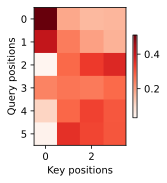

In [29]:
d2l.show_heatmaps(attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(), 
                  xlabel='Key positions', ylabel='Query positions')